In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
# print(calc_temps('2012-02-28', '2012-03-05'))

In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

## Set start of vacation date
start_date = '2017-08-01'

## Compute one year from start date
minus_one_year = dt.datetime.strptime(start_date, "%Y-%m-%d").date() - relativedelta(years=1)
minus_one_year = dt.datetime.strftime(minus_one_year, "%Y-%m-%d")

## Get tmin, tavg & tmax for one year
tmin, tavg, tmax = calc_temps(minus_one_year, start_date)[0]

## Print results
print(f"Temperatures from {minus_one_year} to {start_date}:")
print(f"   tmin = {tmin:.2f} °F")
print(f"   tavg = {tavg:.2f} °F")
print(f"   tmax = {tmax:.2f} °F")

Temperatures from 2016-08-01 to 2017-08-01:
   tmin = 58.00 °F
   tavg = 74.64 °F
   tmax = 87.00 °F


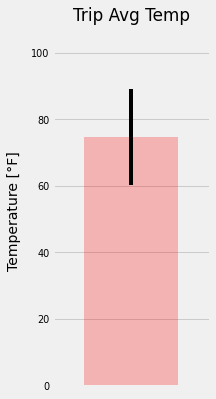

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

## Compute error bar (+/-) value
yerr = (tmax-tmin)/2

## Set figure size
plt.figure(figsize=(2.5,6))

## Plot bar chart
plt.bar(x=.5, height=tavg, width=0.6, yerr=yerr, color='red', alpha=0.25)

## Set plot title and labels
plt.title("Trip Avg Temp", pad=15, fontsize="large")
plt.ylabel("Temperature [°F]", labelpad=10, fontsize="medium")

## Set limits & Format ticks
plt.xlim(0,1)
plt.ylim(0,100+5)
plt.xticks(ticks=[])
plt.yticks(ticks=range(0,100+1,20), size="x-small")

## Save & Display plot
plt.savefig('Images/Trip_Avg_Temp.png', bbox_inches='tight')
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

## Select query columns
slct = [Station.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
        func.sum(Measurement.prcp).label('total rainfall')]

## Declare query statement
stmt = session.query(*slct).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= minus_one_year).\
    filter(Measurement.date <= start_date).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).statement

## Store query results into DataFrame
rainfall_totals_df = pd.read_sql(stmt, session.bind)

## Display DataFrame
rainfall_totals_df

,station,name,latitude,longitude,elevation,total rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,157.91
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,79.49
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,54.39
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,39.80
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,34.26
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,17.20
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,4.77


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
# daily_normals("01-01")

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
start = dt.datetime.strptime(start_date, "%Y-%m-%d").date()
end = dt.datetime.strptime(end_date, "%Y-%m-%d").date()
date_range = [start + dt.timedelta(days=i) for i in range(0, (end-start).days+1)]

# Strip off the year and save a list of strings in the format %m-%d
string_list = [date_range[i].strftime("%m-%d") for i in range(len(date_range))]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for string in string_list:
    normals.append(np.ravel(daily_normals(string)))

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, index=date_range, columns=['tmin', 'tavg', 'tmax'])

# Display Dataframe (with style)
normals_df.style.format('{:.2f}')

,tmin,tavg,tmax
2017-08-01,67.00,75.54,83.00
2017-08-02,68.00,75.60,84.00
2017-08-03,70.00,76.61,85.00
2017-08-04,69.00,76.71,84.00
2017-08-05,69.00,76.15,82.00
2017-08-06,67.00,76.25,83.00
2017-08-07,71.00,77.16,83.00


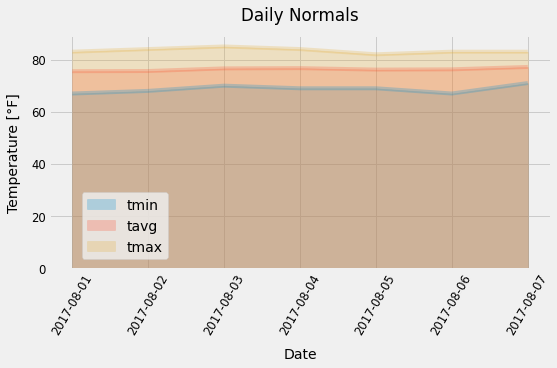

In [32]:
## Plot daily normals as an area plot (stacked=False)
normals_df.plot(figsize=(8,4), kind='area', stacked=False, alpha=0.25, rot=90)

## Set plot title and labels
plt.title("Daily Normals", pad=15, fontsize="large")
plt.xlabel("Date", labelpad=10, fontsize="medium")
plt.ylabel("Temperature [°F]", labelpad=10, fontsize="medium")

## Format ticks
plt.xticks(rotation=60, fontsize="small")
plt.yticks(fontsize="small")

## Set legend
plt.legend(loc='lower left', bbox_to_anchor=(0.05,0.01))

## Save & Display plot
plt.savefig('Images/Daily_Normals.png', bbox_inches='tight')
plt.show()

## Close Session

In [17]:
# Close Session
session.close()